In [1]:
import os
import numpy as np
from simulation_module import SimulationConfig, SimulationState, SimulationRunner, SimulationIO, SimulationVisualizer, AnimationMaker
from laser import Laser
import parralel
from time import time
# from parralel_workers import process_single_rolling_average_density_map
start0 = time()

laser650 = Laser(650, [1,0], saturation = 1, detuning = -2 * np.pi * 20 / 2, Gamma = 2 * np.pi * 20)
laser493 = Laser(493, [1,0], saturation = 1, detuning = -2 * np.pi * 20 / 2, Gamma = 2 * np.pi * 20)


dt_exponent = -3
num_steps_exponent = 6
assert num_steps_exponent < 7, "Probably this will stall the computer"
num_quenches = 20
num_workers = 4
N = 28
gamma = 0.05

input_path = "input"
output_path = "output"
filename = os.path.join(input_path, f"{N}_{gamma}_positions_defect.json")

assert os.path.exists(filename), f"File '{filename}' not found. You need to generate a starting configuration for that value of N, it seems like you don't have one. Try N = 6, gamma = 1 for example."

# SHORT CONFIG
config = SimulationConfig(
    N = N,
    w = 1.0,
    g = gamma,
    m = 137.327,  # mass in atomic units
    T_mK = 0,     # temperature in mK
    dt = 10**dt_exponent,
    num_steps = int(1*10**num_steps_exponent),
    damping = False,
    damping_parameter = 1.0,
    langevin_temperature = False,
    lasers=[laser650],  # or a list of Laser instances
    input_path = input_path,
    output_path = output_path
)

total_steps_per_worker = num_quenches * config.num_steps/num_workers
print(f"Total number of simulated ion-timesteps per worker = {(config.N * total_steps_per_worker / (10**6)):.3f} million ion-steps per worker. Expected time = {(config.N * total_steps_per_worker * 0.000095954544 / 6):.3f} s")

config.save_shortform()

state = SimulationState(config)

IO = SimulationIO()
state.positions = IO.load_positions(filename)
state.initial_positions = state.positions.copy()
state.initialized = True

# Use Eddie's user-specific scratch space
scratch_base = "" #"/exports/eddie/scratch/s2142953"

quench_trajectory_folder = "quench_folder"
animation_folder = "animation_folder"
temperature_folder = "temperature_folder"
animation_output = "animation_output"
rolling_average_output = "rolling_average_output"

Total number of simulated ion-timesteps per worker = 140.000 million ion-steps per worker. Expected time = 2238.939 s


In [ ]:
start = time()
parralel.run_quench_series(
    config = config,
    loadfile = f"{N}_{config.g}_positions_1.json",
    output_dir = quench_trajectory_folder,
    g_start = 0.1,
    g_end = 0.2,
    g_step = num_quenches,
    num_workers = num_workers
)    
print(f"Time taken to quench = {time()-start:.3f} s")

Beginning to parralel quench


In [3]:
start = time()
parralel.plot_defect_plots(
    final_positions_folder = "quench_folder_final_positions",
    output_dir = "defect_plots",
    base_config = config,          # your SimulationConfig
    num_workers = num_workers,            # or an int
    tol = None,                   # When tolerance is set to None it calculates the tolerance as 10% of the max range
    square=False,
    extension="png"
)
print(f"Time taken to process defect plots = {time()-start:.3f} s")

🧵 Generating defect plots from 20 files in parallel...
No defects: perfect zigzag among non-center ions (mean_x=1.26673).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.184211.png
No defects: perfect zigzag among non-center ions (mean_x=1.06187).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.168421.png
No defects: perfect zigzag among non-center ions (mean_x=0.93994).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.157895.png
No defects: perfect zigzag among non-center ions (mean_x=0.653956).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.131579.png
No defects: perfect zigzag among non-center ions (mean_x=0.453602).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.110526.png
No defects: perfect zigzag among non-center ions (mean_x=1.41301).
Figure(800x800)
🧩 Saved defect plot → output/defect_plots/defect_plot_gamma_0.194737.png
No defe

In [4]:
start = time()
parralel.generate_rolling_average_density_map_images_from_quench_folder(
    traj_folder = quench_trajectory_folder,
    output_dir = rolling_average_output,
    base_config = config,
    time_per_image = 100,
    overlapping_time = 0,
    full_histogram = True,
    animate = True,
    num_workers = num_workers)
print(f"Time taken to generate rolling images = {time()-start:.3f} s")

🔁 Beginning parallel rolling-average density map generation


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
IMAGEIO FFMPEG_WRITER WARNING: input ima

Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_000_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_001_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_002_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_003_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_004_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_005_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_006_gamma_0.200000.png
Saved output/rolling_average_output/28_0.20000000000000_traj_1000000_steps/rolling_frame_000_window_007_gamma_0.200000.png
Saved output/rol

✅ All rolling-average density maps generated.
Time taken to generate rolling images = 1832.580 s


In [3]:
start = time()
parralel.generate_density_map_images_from_quench_folder(quench_trajectory_folder, 
                                                        animation_folder, 
                                                        config, 
                                                        num_workers = num_workers,
                                                       square = False                                                       )
print(f"Time taken to process images = {time()-start:.3f} s")

Beginning to parralel process trajectory files
Processing output/quench_folder/28_0.18421052631579_traj_1000000_steps.json
Processing output/quench_folder/28_0.16842105263158_traj_1000000_steps.json
Processing output/quench_folder/28_0.14210526315789_traj_1000000_steps.json
Processing output/quench_folder/28_0.12105263157895_traj_1000000_steps.json
Processing output/quench_folder/28_0.10000000000000_traj_1000000_steps.json
Processing output/quench_folder/28_0.19473684210526_traj_1000000_steps.json
Processing output/quench_folder/28_0.16315789473684_traj_1000000_steps.json
Processing output/quench_folder/28_0.14736842105263_traj_1000000_steps.json
Processing output/quench_folder/28_0.12631578947368_traj_1000000_steps.json
Processing output/quench_folder/28_0.10526315789474_traj_1000000_steps.json
Processing output/quench_folder/28_0.20000000000000_traj_1000000_steps.json
Processing output/quench_folder/28_0.17894736842105_traj_1000000_steps.json
Processing output/quench_folder/28_0.1578

In [2]:
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################
###########################################################################################

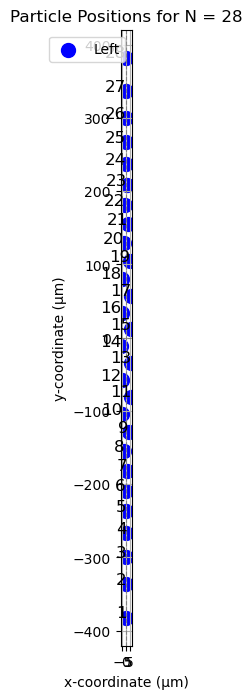

In [2]:
from parralel_workers import *
filename = os.path.join(output_path, quench_trajectory_folder, "28_0.10526315789474_traj_1000000_steps.json")
assert os.path.exists(filename), f"File '{filename}' not found."

IO = SimulationIO()
state.positions = get_final_positions(filename)
state.initialized = True

# Visualize the ion positions and save the results to file. Note that both 'save' and 'filename' are optional
SimulationVisualizer().plot_positions(state)

No defects: perfect zigzag among non-center ions (mean_x=0.41796).


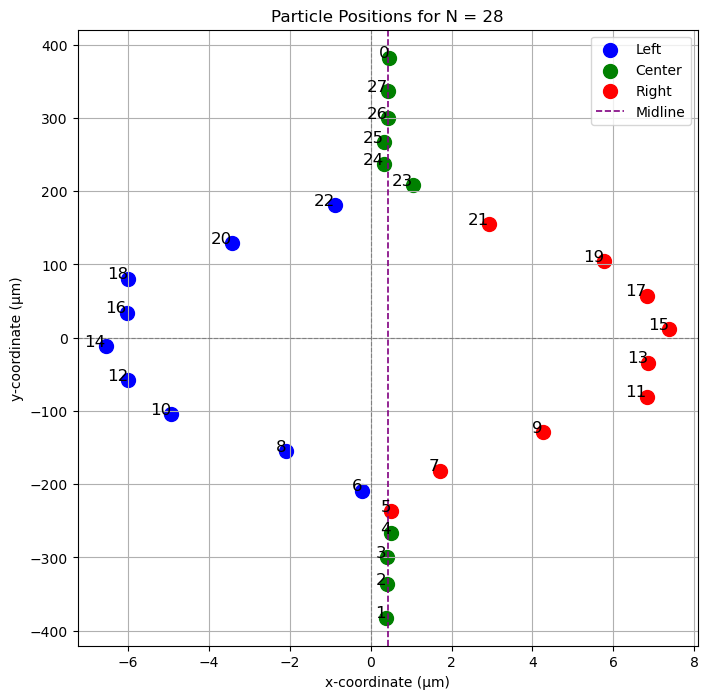

In [9]:
zigzag, defects, left, right, center = check_single_for_defect(state.positions, tol = 0.5)
SimulationVisualizer().plot_positions(state, square = False, left = right, center = center, right = left, midline = True, defects = defects)

In [1]:
# import shutil
# import os

# # List of folder names to remove
# folders_to_delete = [output_path]  

# for folder in folders_to_delete:
#     if os.path.exists(folder) and os.path.isdir(folder):
#         shutil.rmtree(folder)
#         print(f"Deleted folder: {folder}")
#     else:
#         print(f"Folder not found or not a directory: {folder}")

Folder not found or not a directory: animation_output
Folder not found or not a directory: animation_folder
Folder not found or not a directory: quench_folder
Folder not found or not a directory: temperature_folder
Folder not found or not a directory: rolling_average_output
Deleted folder: output


In [4]:
start = time()
os.makedirs(os.path.join(output_path,animation_output), exist_ok = True)
AnimationMaker.make_gif_or_mp4_from_images(os.path.join(output_path,animation_folder), f"{output_path}/{animation_output}/--output_animation_dt_1e{dt_exponent}_num_1e{num_steps_exponent}_time_{int(10**(dt_exponent+num_steps_exponent))}us.mp4", fps=6, reverse = True)
print(f"Time taken to make animation = {time()-start:.3f} s")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 600) to (608, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MP4 saved via imageio: output/animation_output/--output_animation_dt_1e-3_num_1e5_time_100us.mp4
Time taken to make animation = 0.136 s


In [5]:
start = time()
parralel.generate_temperature_plots_from_quench_folder(quench_trajectory_folder,temperature_folder,config, grainyness=100,num_workers=num_workers)
print(f"Time taken to make temperature plots {time()-start:.5f} s")

🔁 Beginning parallel temperature plot generation
Generating temperature plot for output/quench_folder/28_0.18421052631579_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.16315789473684_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.14210526315789_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.12631578947368_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.10526315789474_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.19473684210526_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.17368421052632_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.14736842105263_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.12105263157895_traj_1000000_steps.json
Generating temperature plot for output/quench_folder/28_0.10000000000000_traj_

In [7]:
# start = time()
# os.makedirs(os.path.join(output_path,animation_output), exist_ok = True)
# AnimationMaker.make_gif_or_mp4_from_images(os.path.join(output_path,temperature_folder), f"{output_path}/{animation_output}/--temperature_output_animation_dt_1e{dt_exponent}_num_1e{num_steps_exponent}_time_{int(10**(dt_exponent+num_steps_exponent))}us.mp4", fps=6, reverse = True)
# print(f"Time taken to make animation = {time()-start:.3f} s")